# SMC and ACA Data analysis

Import diferent libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import timeit
import datetime
import xgboost as xgb
import math
import joblib

# libraries for import all file names
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression


ACA agafar de riuades --> 23/01/2020  13:30:00

## Dataframes

In [2]:
# SMC
Df_SMC_Total = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
#['CC', 'CG', 'CI', 'CY', 'DG', 'DJ', 'DN', 'KE', 'UB', 'UN', 'UO', 'V3','V4', 'V5', 'VN', 'WS', 'DM_XJ_WF', 'Z4_ZC']

In [3]:
# ACA 
Df_ACA_AltTer = pd.read_excel("dataACA/Dataframes/df_imputedAltTer.xlsx")
Df_ACA_AltTer = Df_ACA_AltTer.set_index('DATA')

Df_ACA_BaixTer = pd.read_excel("dataACA/Dataframes/df_imputedBaixTer.xlsx")
Df_ACA_BaixTer = Df_ACA_BaixTer.set_index('DATA')

## Dataframe n enrrere

In [4]:
# 1a versio --> molt lenta
DATAFRAME = pd.DataFrame()
COLUMNNAME = ""
def example(x):
    global DATAFRAME, COLUMNNAME
    xNumpy = x.to_numpy()
    xFrame = x.to_frame()
    ultimNumberIndex = len(xNumpy)-1
    rowIndex = xFrame.iloc[ultimNumberIndex].name
    
    for index in xFrame.index:
        if (index != rowIndex):
            time = (rowIndex - index)
            newColumnName = COLUMNNAME + " - " + str(time) 
            DATAFRAME.at[rowIndex,newColumnName] = xFrame.loc[index][0]   
    
    return xNumpy[-1]

def makeDf(dataFrame,num):
    global DATAFRAME, COLUMNNAME
    DATAFRAME = dataFrame.copy()

    for column in dataFrame.columns:
        dfColumn = dataFrame[[column]]
        COLUMNNAME = column
        dfColumn.rolling(window = num).apply(example)

    
    return DATAFRAME


In [5]:
def makeDf2(dataFrame,num):
    dataFrameAux = dataFrame.copy()

    for column in dataFrame.columns:
        dfColumn = dataFrame[[column]]
        for x in range(1,num+1):
            date_range = pd.date_range("2009-01-01", periods=210385, freq="30T")
            date_range = date_range.shift(x, freq='30T')
            dfNewcolumn = pd.DataFrame({'DATA':date_range}).set_index('DATA')
            dfColumnNy = dfColumn.to_numpy()
            dfNewcolumn[column + " - " + str(dfNewcolumn.iloc[0].name - dfColumn.iloc[0].name)] = dfColumnNy
            dataFrameAux = dataFrameAux.join(dfNewcolumn, how='left')

    return dataFrameAux

In [6]:
def makeDfY(dataFrame,num):
    dataFrameAux = dataFrame.copy()

    for column in dataFrame.columns:
        date_rangeBase = pd.date_range("2009-01-01", periods=210385, freq="30T")
        dfBase = pd.DataFrame({'DATA':date_rangeBase}).set_index('DATA')
        date_range = pd.date_range("2009-01-01", periods=210385, freq="30T")
        date_range = date_range.shift(-num, freq='30T')
        dfNewcolumn = pd.DataFrame({'DATA':date_range}).set_index('DATA')
        dfColumn = dataFrame[[column]]
        dfColumnNy = dfColumn.to_numpy()
        dfNewcolumn[column + " + " + str(dfColumn.iloc[0].name - dfNewcolumn.iloc[0].name )] = dfColumnNy
        
        dfBase = dfBase.join(dfNewcolumn, how='left')

    return dfBase

### Part alta del riu 

In [7]:
Df_SMC_AltTer = Df_SMC_Total[['CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4','V5', 'WS', 'Z4_ZC']]
Df_AltTer = Df_ACA_AltTer.join(Df_SMC_AltTer, how='left')

In [8]:
Df_AltTery = Df_AltTer[['L08116-72-00002']] # a masies de roda
Df_AltTerX = Df_AltTer[['L17147-72-00005','L08116-72-00002','L17167-72-00001','CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4','V5', 'WS', 'Z4_ZC']]

#agafar totes les dades iguals menys la variable predictora 12h mes tard ## FINAL ##
Df_AltTerX_24hpred = Df_AltTerX.copy()
Df_AltTery_24hpredNaN = makeDfY(Df_AltTery,48)

Df_AltTery_24hpred = Df_AltTery_24hpredNaN.dropna()

Df_AltTerX_24hpred = Df_AltTerX_24hpred[Df_AltTerX_24hpred.head(1).index.item():Df_AltTery_24hpred.tail(1).index.item()]
Df_AltTery_24hpred = Df_AltTery_24hpred[Df_AltTerX_24hpred.head(1).index.item():Df_AltTery_24hpred.tail(1).index.item()]

### Part baixa del riu 

In [9]:
Df_SMC_BaixTer = Df_SMC_Total[[ 'DJ', 'DN', 'KE', 'UB', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF']]
Df_BaixTer = Df_ACA_BaixTer.join(Df_SMC_BaixTer, how='left')

In [10]:
#Df_BaixTer

In [11]:
#agafar totes les dades iguals menys la variable predictora 24h mes tard
# 'L17199-72-00001' 'UB' treta 

Df_BaixTery = Df_BaixTer[['L17055-72-00002']] # colomers
Df_BaixTerX = Df_BaixTer[['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF']]

Df_BaixTerX_24hpred = Df_BaixTerX.copy()
Df_BaixTery_24hpredNaN = makeDfY(Df_BaixTery,48)

Df_BaixTery_24hpred = Df_BaixTery_24hpredNaN.dropna()

Df_BaixTerX_24hpred = Df_BaixTerX_24hpred[Df_BaixTerX_24hpred.head(1).index.item():Df_BaixTery_24hpred.tail(1).index.item()]
Df_BaixTery_24hpred = Df_BaixTery_24hpred[Df_BaixTerX_24hpred.head(1).index.item():Df_BaixTery_24hpred.tail(1).index.item()]


### Tot el riu

In [12]:
Df_Ter = Df_ACA_BaixTer.join(Df_ACA_AltTer, how='left').join(Df_SMC_Total, how='left')

In [ ]:
#Df_Ter

In [ ]:
Df_Ter.to_excel("finalsDF/Df_Ter.xlsx")

## Analisis Model

https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

https://machinelearningmastery.com/xgboost-for-regression/ 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html --> grid search

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html --> timeSeries Split

Randomforest

ExtraTrees

exboost

------------------------------------- Random Forest Regressor -----------------------------------------------

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### Part alta del riu

In [13]:
df_results_altTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

#### Random Forest

Iteració:  1
CPU times: total: 3.33 s
Wall time: 1min 45s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\3547751411.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


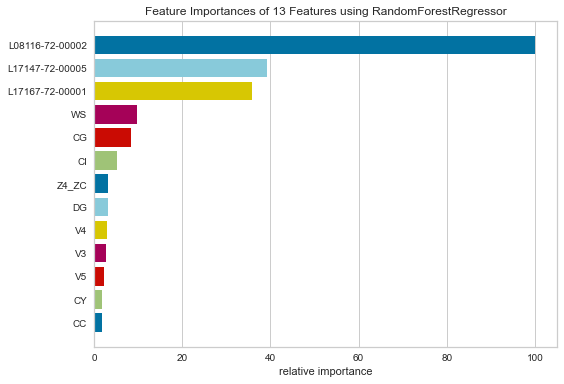

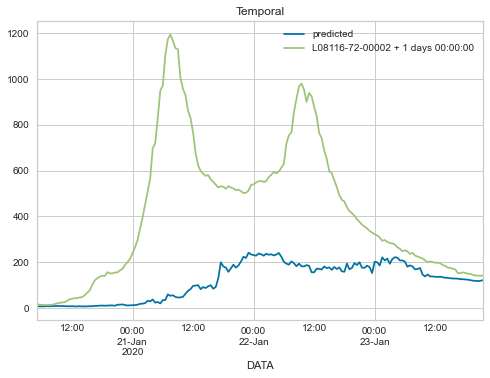

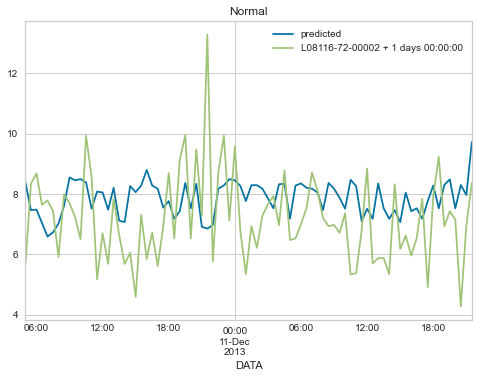

Iteració:  2
CPU times: total: 4.56 s
Wall time: 4min 20s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\3547751411.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


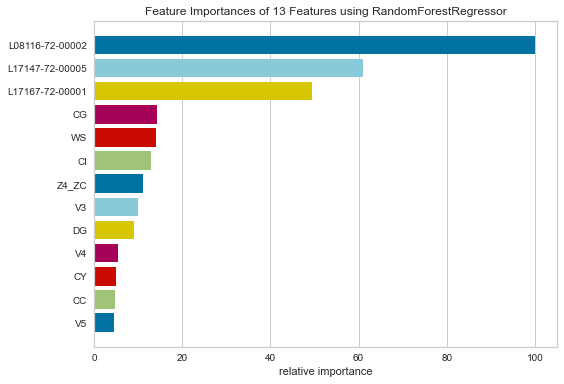

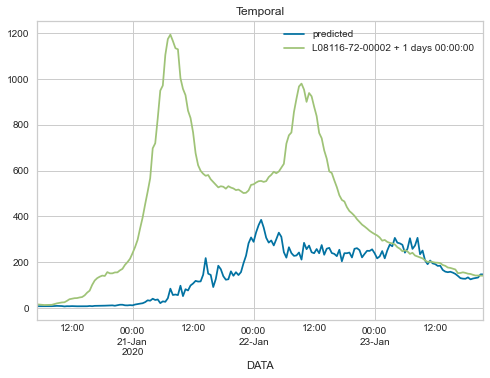

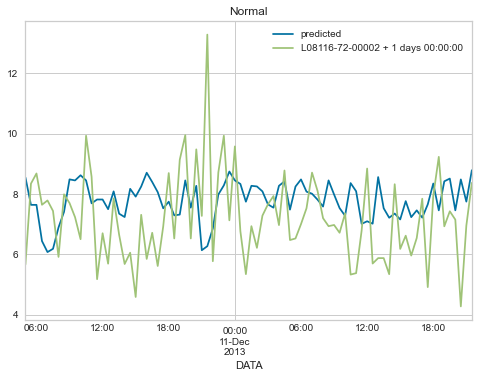

Iteració:  3
CPU times: total: 15.9 s
Wall time: 7min 16s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\3547751411.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


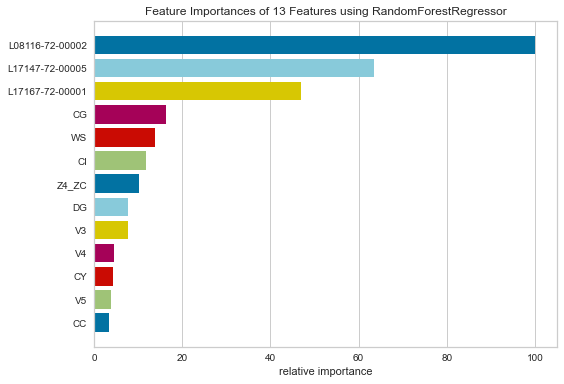

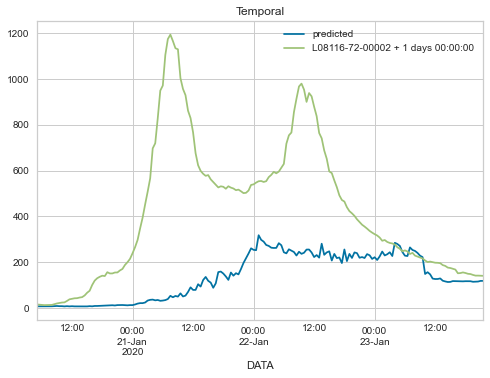

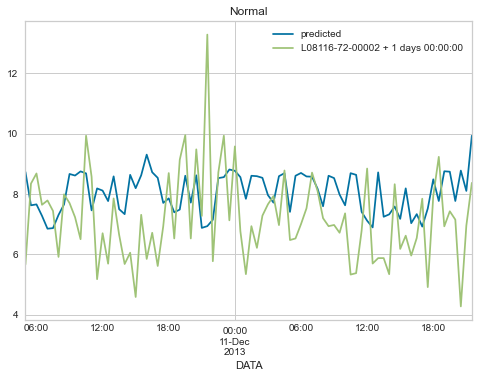

Time:  0:13:26.141803


In [14]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_AltTery_24hpred
#Df_AltTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_AltTerX_24hpred):
    iteracio += 1
    Df_AltTerX_24hpred_train, Df_AltTerX_24hpred_test = Df_AltTerX_24hpred.values[train_index], Df_AltTerX_24hpred.values[test_index]
    Df_AltTery_24hpred_train, Df_AltTery_24hpred_test = Df_AltTery_24hpred.values.ravel()[train_index], Df_AltTery_24hpred.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltTerX_24hpred_train, Df_AltTery_24hpred_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltTerX_24hpred_test, Df_AltTery_24hpred_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_AltTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_AltTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_AltTerX_24hpred.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/RandomForest_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltTerX_24hpred, Df_AltTery_24hpred)
    viz.show()
    
    plotYtest = Df_AltTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_AltTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))


In [15]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.18078640797928794, 0.46202659175183536, 0.1...",0.350251,21.771579,1 days 00:00:00
1,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.20205816773926552, 0.33125397603075196, 0.1...",0.176638,13.506175,1 days 00:00:00
2,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.21602726931242175, 0.34006943839980286, 0.1...",0.324907,34.007339,1 days 00:00:00


#### XGBoost

Iteració:  1
[12:37:48] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 13.8 s
Wall time: 5min 46s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1917994367.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


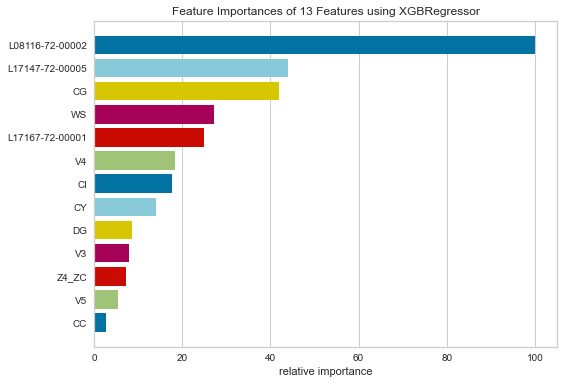

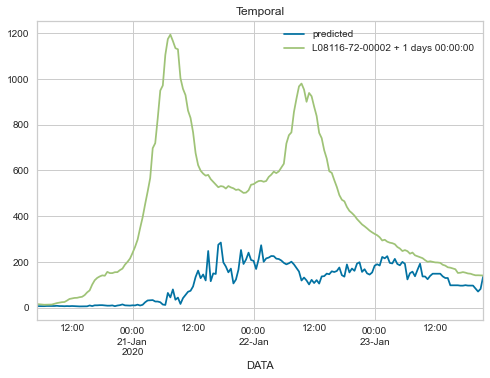

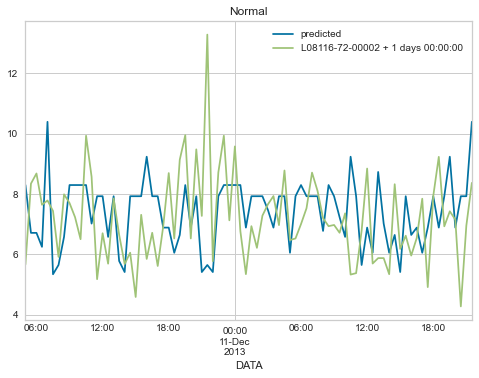

Iteració:  2
[12:47:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 2min 44s
Wall time: 10min 9s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1917994367.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


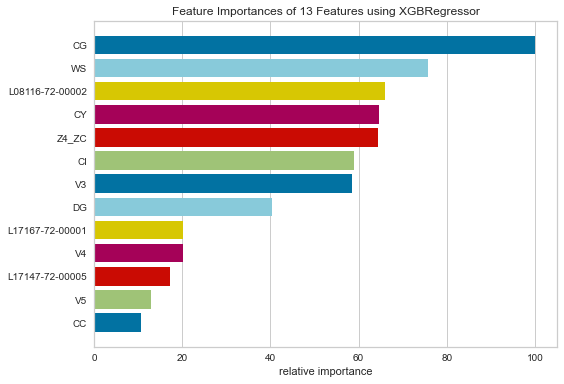

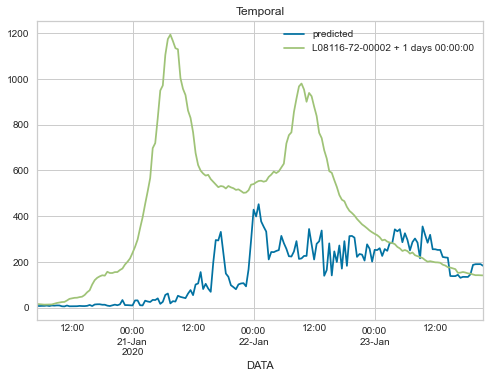

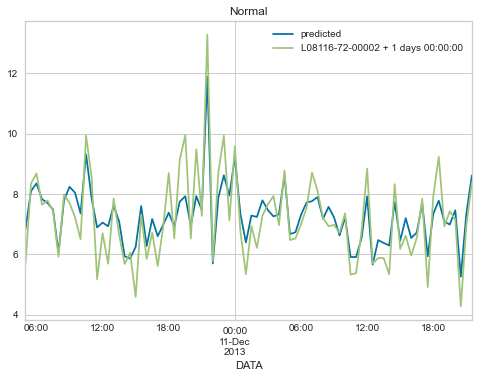

Iteració:  3
[13:01:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 41.5 s
Wall time: 13min 6s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1917994367.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


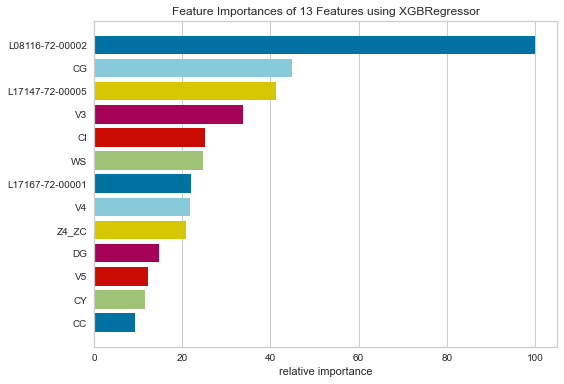

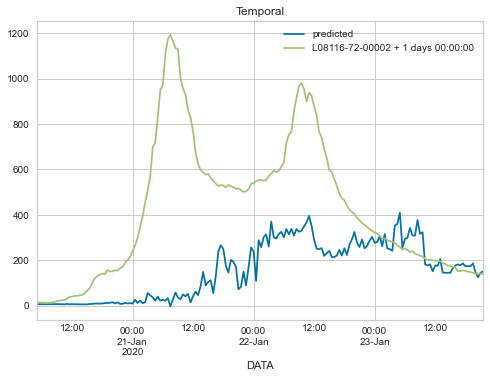

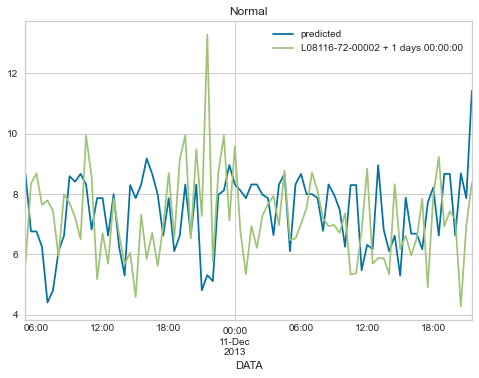

Time:  0:29:06.240915


In [16]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_AltTery_24hpred
#Df_AltTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_AltTerX_24hpred):
    iteracio += 1
    Df_AltTerX_24hpred_train, Df_AltTerX_24hpred_test = Df_AltTerX_24hpred.values[train_index], Df_AltTerX_24hpred.values[test_index]
    Df_AltTery_24hpred_train, Df_AltTery_24hpred_test = Df_AltTery_24hpred.values.ravel()[train_index], Df_AltTery_24hpred.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltTerX_24hpred_train, Df_AltTery_24hpred_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltTerX_24hpred_test, Df_AltTery_24hpred_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_AltTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_AltTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'XGBoost Regressor','Best_Params':bestParams, 'Features':Df_AltTerX_24hpred.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBRegressor_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltTerX_24hpred, Df_AltTery_24hpred)
    viz.show()
    
    plotYtest = Df_AltTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_AltTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [17]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.18078640797928794, 0.46202659175183536, 0.1...",0.350251,21.771579,1 days 00:00:00
1,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.20205816773926552, 0.33125397603075196, 0.1...",0.176638,13.506175,1 days 00:00:00
2,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.21602726931242175, 0.34006943839980286, 0.1...",0.324907,34.007339,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.13729776, 0.3124329, 0.077890694, 0.0087660...",0.303154,22.546818,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.028134793, 0.108188584, 0.033323053, 0.0173...",-0.108233,15.669402,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.10767025, 0.26167366, 0.05731047, 0.0243465...",0.309775,34.38635,1 days 00:00:00


#### ExtraTrees

Iteració:  1
CPU times: total: 3.31 s
Wall time: 1min 30s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\4069587599.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


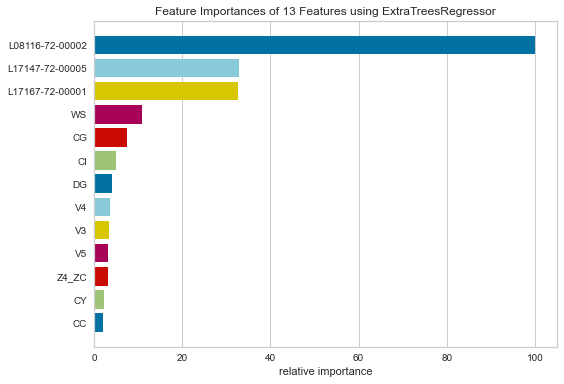

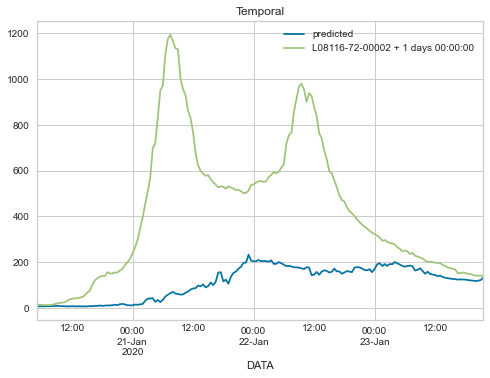

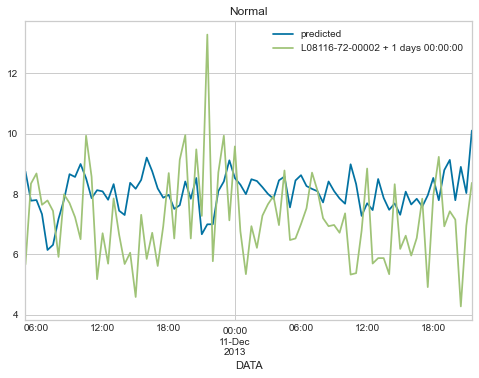

Iteració:  2
CPU times: total: 11.3 s
Wall time: 3min 54s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\4069587599.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


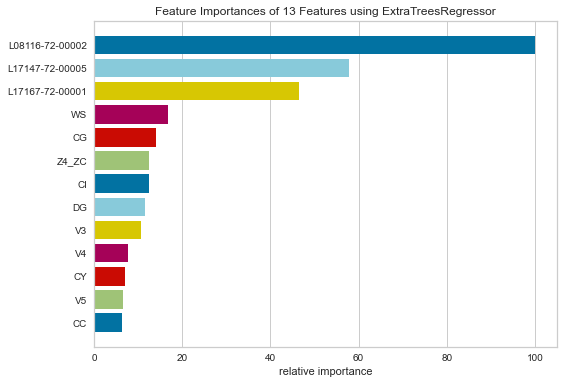

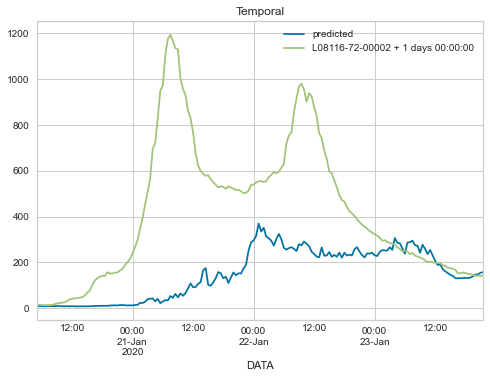

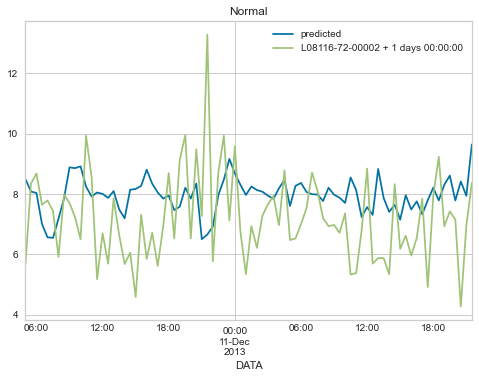

Iteració:  3
CPU times: total: 17 s
Wall time: 6min 41s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\4069587599.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


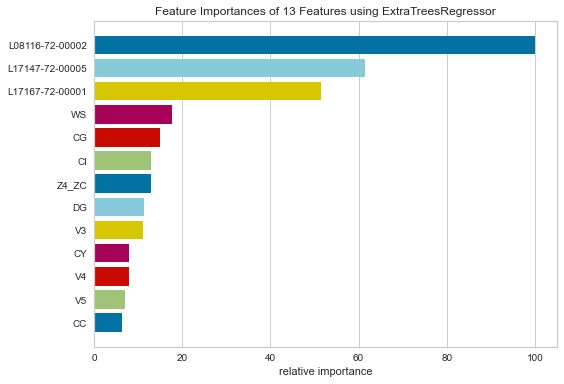

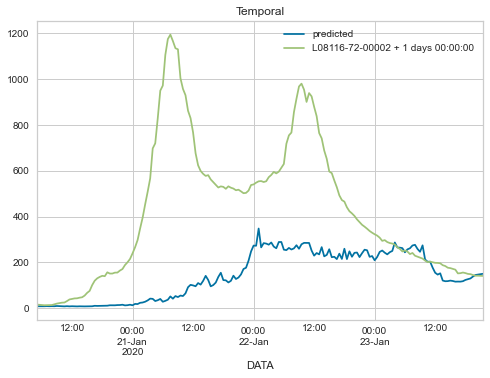

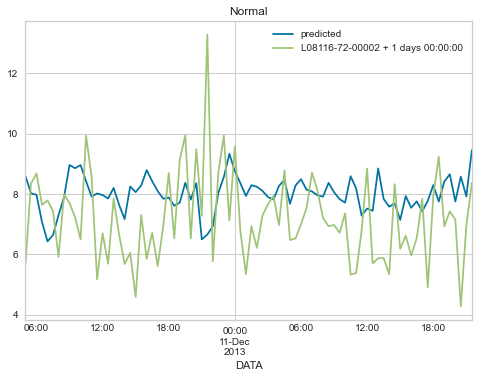

Time:  0:12:17.301431


In [18]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_AltTery_24hpred
#Df_AltTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_AltTerX_24hpred):
    iteracio += 1
    Df_AltTerX_24hpred_train, Df_AltTerX_24hpred_test = Df_AltTerX_24hpred.values[train_index], Df_AltTerX_24hpred.values[test_index]
    Df_AltTery_24hpred_train, Df_AltTery_24hpred_test = Df_AltTery_24hpred.values.ravel()[train_index], Df_AltTery_24hpred.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltTerX_24hpred_train, Df_AltTery_24hpred_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltTerX_24hpred_test, Df_AltTery_24hpred_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_AltTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_AltTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'ExtraTreesRegressor','Best_Params':bestParams, 'Features':Df_AltTerX_24hpred.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/ExtraTreesRegressor_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltTerX_24hpred, Df_AltTery_24hpred)
    viz.show()
    
    plotYtest = Df_AltTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_AltTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [19]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.18078640797928794, 0.46202659175183536, 0.1...",0.350251,21.771579,1 days 00:00:00
1,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.20205816773926552, 0.33125397603075196, 0.1...",0.176638,13.506175,1 days 00:00:00
2,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.21602726931242175, 0.34006943839980286, 0.1...",0.324907,34.007339,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.13729776, 0.3124329, 0.077890694, 0.0087660...",0.303154,22.546818,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.028134793, 0.108188584, 0.033323053, 0.0173...",-0.108233,15.669402,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.10767025, 0.26167366, 0.05731047, 0.0243465...",0.309775,34.38635,1 days 00:00:00
6,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.15607399151860574, 0.47399261995522907, 0.1...",0.346912,21.827447,1 days 00:00:00
7,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.18637364783842686, 0.32224874259255515, 0.1...",0.212275,13.210653,1 days 00:00:00
8,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.19001967081291174, 0.3097086232019651, 0.15...",0.328382,33.919703,1 days 00:00:00


#### Regresió Linial

Iteració:  1
CPU times: total: 141 ms
Wall time: 110 ms


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1460692804.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


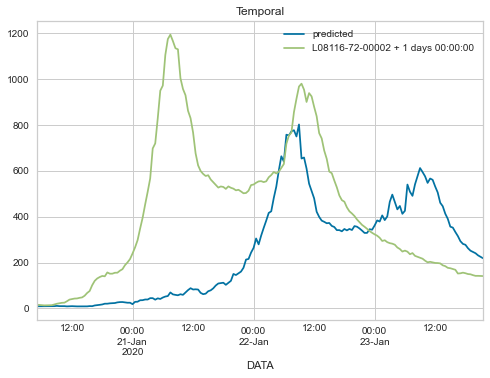

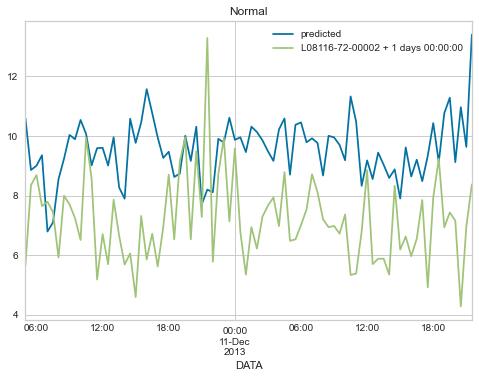

Iteració:  2
CPU times: total: 109 ms
Wall time: 28.9 ms


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1460692804.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


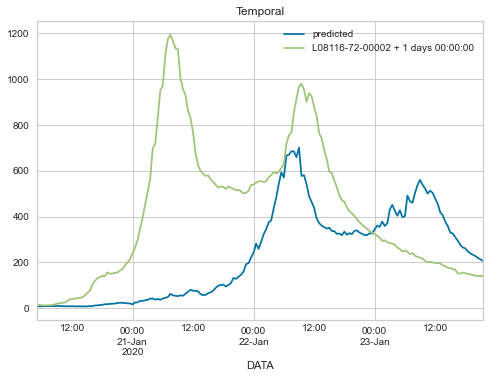

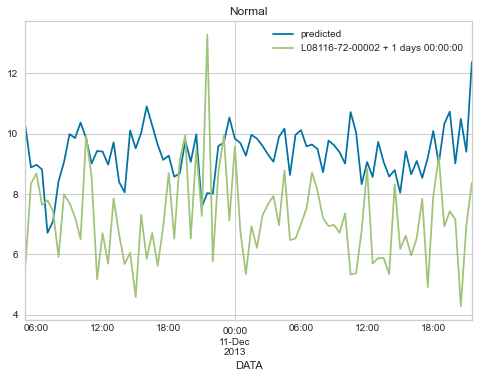

Iteració:  3
CPU times: total: 219 ms
Wall time: 50.9 ms


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1460692804.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)


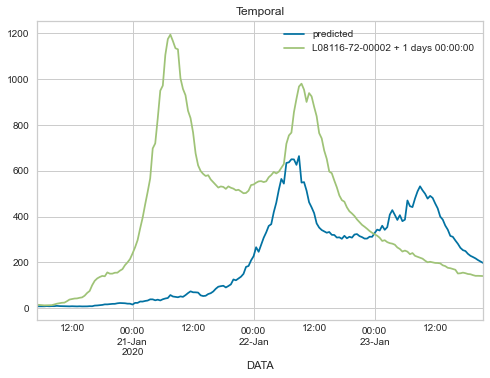

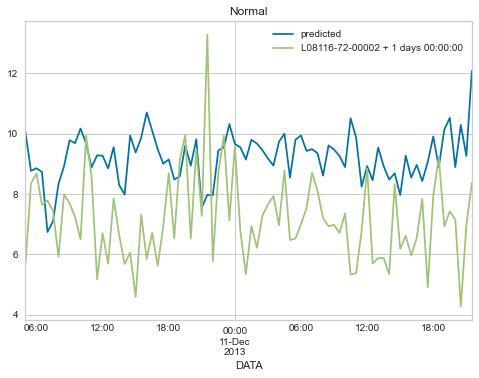

Time:  0:00:06.151455


In [20]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_AltTery_24hpred
#Df_AltTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_AltTerX_24hpred):
    iteracio += 1
    Df_AltTerX_24hpred_train, Df_AltTerX_24hpred_test = Df_AltTerX_24hpred.values[train_index], Df_AltTerX_24hpred.values[test_index]
    Df_AltTery_24hpred_train, Df_AltTery_24hpred_test = Df_AltTery_24hpred.values.ravel()[train_index], Df_AltTery_24hpred.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltTerX_24hpred_train, Df_AltTery_24hpred_train)
        
    score = modelfited.score(Df_AltTerX_24hpred_test, Df_AltTery_24hpred_test)
    
    predicty = modelfited.predict(Df_AltTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_AltTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_AltTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'LinearRegression','Best_Params':"no avaliable", 'Features':Df_AltTerX_24hpred.columns, 'Feature_Importance':"no avaliable", 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(modelfited, 'resultsDf/pickle/partAlta/ExtraTreesRegressor_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtest = Df_AltTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_AltTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = modelfited.predict(plotXtestp.values)
    plotXtest2r = modelfited.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [21]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.18078640797928794, 0.46202659175183536, 0.1...",0.350251,21.771579,1 days 00:00:00
1,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.20205816773926552, 0.33125397603075196, 0.1...",0.176638,13.506175,1 days 00:00:00
2,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.21602726931242175, 0.34006943839980286, 0.1...",0.324907,34.007339,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.13729776, 0.3124329, 0.077890694, 0.0087660...",0.303154,22.546818,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.028134793, 0.108188584, 0.033323053, 0.0173...",-0.108233,15.669402,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.10767025, 0.26167366, 0.05731047, 0.0243465...",0.309775,34.38635,1 days 00:00:00
6,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.15607399151860574, 0.47399261995522907, 0.1...",0.346912,21.827447,1 days 00:00:00
7,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.18637364783842686, 0.32224874259255515, 0.1...",0.212275,13.210653,1 days 00:00:00
8,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L08116-72-00002', '...","[0.19001967081291174, 0.3097086232019651, 0.15...",0.328382,33.919703,1 days 00:00:00
9,LinearRegression,no avaliable,"Index(['L17147-72-00005', 'L08116-72-00002', '...",no avaliable,0.268119,23.106667,00


In [40]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.18078640797928794, 0.46202659175183536, 0.16503526686908931, 0.008529010393631787, 0.03897723624141299, 0.024112076195114705, 0.008855436056206143, 0.014254663199784499, 0.012523273486239817, 0.014088789041725662, 0.01079136220265008, 0.04547102079270204, 0.01454886579031962]",0.350251,21.771579,1 days 00:00:00
1,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.20205816773926552, 0.33125397603075196, 0.16376680313899925, 0.016018784761167786, 0.04746647585366645, 0.042894063728360056, 0.016845329177516365, 0.02978755218548125, 0.033331653676550034, 0.018190849381093856, 0.015118082674365667, 0.04674366319616543, 0.03652459845661651]",0.176638,13.506175,1 days 00:00:00
2,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.21602726931242175, 0.34006943839980286, 0.15948920948836276, 0.011438915307903233, 0.05517050545507773, 0.04006074841071579, 0.014607423053794966, 0.02641982724484591, 0.02636689722499742, 0.015347549178801703, 0.0131604889135106, 0.04706554308053485, 0.034776184929230555]",0.324907,34.007339,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_estimators': 50}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.13729776, 0.3124329, 0.077890694, 0.008766092, 0.1306806, 0.055532247, 0.043652736, 0.027048096, 0.024549227, 0.057109565, 0.017250586, 0.08486711, 0.022922415]",0.303154,22.546818,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': 25, 'max_features': 1, 'n_estimators': 50}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.028134793, 0.108188584, 0.033323053, 0.017333046, 0.16420627, 0.096603386, 0.10592702, 0.06614422, 0.09590034, 0.033230066, 0.021250851, 0.12416892, 0.10558949]",-0.108233,15.669402,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_estimators': 50}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.10767025, 0.26167366, 0.05731047, 0.024346534, 0.11763438, 0.065687984, 0.030311702, 0.03863548, 0.08861965, 0.057064112, 0.031759776, 0.064633414, 0.05465261]",0.309775,34.38635,1 days 00:00:00
6,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 100}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.15607399151860574, 0.47399261995522907, 0.15437628534452755, 0.009319234088383784, 0.03585497723592673, 0.02387695494546681, 0.010984026261117408, 0.019357666895429476, 0.016029907201233474, 0.01769697943741068, 0.01553882100940632, 0.051394227468656316, 0.015504308638606823]",0.346912,21.827447,1 days 00:00:00
7,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 200}","Index(['L17147-72-00005', 'L08116-72-00002', 'L17167-72-00001', 'CC', 'CG', 'CI', 'CY', 'DG', 'V3', 'V4', 'V5', 'WS', 'Z4_ZC'], dtype='object')","[0.18637364783842686, 0.32224874259255515, 0.14958603744522372, 0.020835486843415556, 0.04535433653737907, 0.04030745986693417, 0.022912719836397706, 0.03707351973811048, 0.034709530367914354, 0.024517014472753805, 0.0215240233

In [22]:
df_results_altTer.to_excel("resultsDf/dfmodels/DfResult_AltTer.xlsx")

### Part baixa del riu 

In [23]:
df_results_baixTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

#### Random Forest

Iteració:  1
CPU times: total: 3.14 s
Wall time: 1min 37s
Best_params_ {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy for RandomForestRegressor on data:  0.47654696530433205
Feature_importance:  [0.0757312  0.09786759 0.25115171 0.15770228 0.0487598  0.26059892
 0.01081801 0.01250897 0.00954625 0.01209632 0.01104662 0.0128515
 0.03489488 0.00442596]


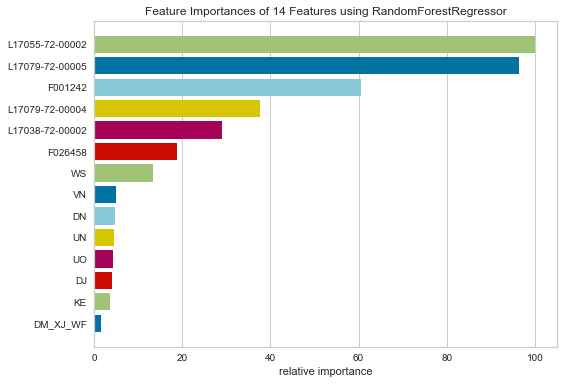

Iteració:  2
CPU times: total: 12.4 s
Wall time: 4min 5s
Best_params_ {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
Accuracy for RandomForestRegressor on data:  0.28389221403453757
Feature_importance:  [0.08466689 0.1112954  0.19907609 0.18204082 0.03583352 0.21800087
 0.0275048  0.01668087 0.01815665 0.01573543 0.01388766 0.01088444
 0.05418045 0.01205612]


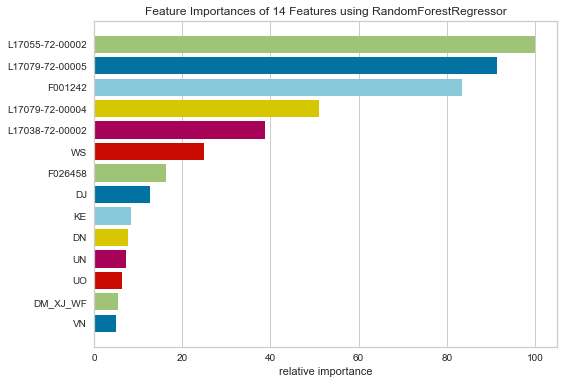

Iteració:  3
CPU times: total: 18.4 s
Wall time: 7min
Best_params_ {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
Accuracy for RandomForestRegressor on data:  0.4858249789572928
Feature_importance:  [0.08640771 0.10745272 0.1971452  0.19570858 0.04067163 0.21330009
 0.02444502 0.01329405 0.01698567 0.01341075 0.01567747 0.01270443
 0.05120845 0.01158824]


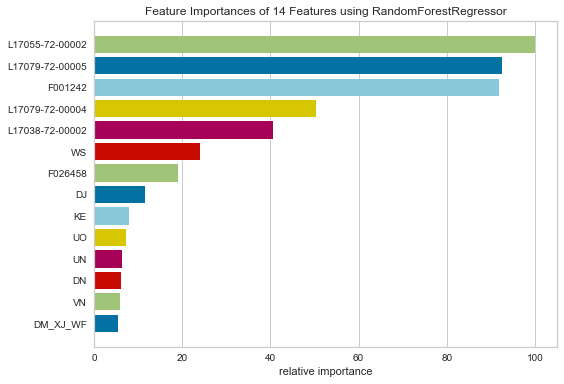

Time:  0:12:54.006744


Iteració,best_params_,score,feature_importance()
1,"{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}",0.47654696530433205,[0.0757312 0.09786759 0.25115171 0.15770228 0.0487598 0.26059892 0.01081801 0.01250897 0.00954625 0.01209632 0.01104662 0.0128515 0.03489488 0.00442596]
2,"{'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}",0.28389221403453757,[0.08466689 0.1112954 0.19907609 0.18204082 0.03583352 0.21800087 0.0275048 0.01668087 0.01815665 0.01573543 0.01388766 0.01088444 0.05418045 0.01205612]
3,"{'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}",0.4858249789572928,[0.08640771 0.10745272 0.1971452 0.19570858 0.04067163 0.21330009 0.02444502 0.01329405 0.01698567 0.01341075 0.01567747 0.01270443 0.05120845 0.01158824]


In [24]:
start = timeit.default_timer()

myTable = PrettyTable(["Iteració", "best_params_", "score","feature_importance()"])
tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_AltTery_24hpred
#Df_AltTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_BaixTerX_24hpred):
    iteracio += 1
    Df_BaixTerX_24hpred_train, Df_BaixTerX_24hpred_test = Df_BaixTerX_24hpred.values[train_index], Df_BaixTerX_24hpred.values[test_index]
    Df_BaixTery_24hpred_train, Df_BaixTery_24hpred_test = Df_BaixTery_24hpred.values.ravel()[train_index], Df_BaixTery_24hpred.values.ravel()[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)
    #print("TRAIN:", Df_AltTerX_24hpred_train, "TEST:", Df_AltTerX_24hpred_test)
    #print("TRAIN:", Df_AltTery_24hpred_train, "TEST:", Df_AltTery_24hpred_test)
    model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixTerX_24hpred_train, Df_BaixTery_24hpred_train)
    print("Best_params_" , gsearchfited.best_params_)
    print("Accuracy for RandomForestRegressor on data: ",gsearchfited.score(Df_BaixTerX_24hpred_test, Df_BaixTery_24hpred_test))
    print("Feature_importance: ",gsearchfited.best_estimator_.feature_importances_)
    myTable.add_row([iteracio, gsearchfited.best_params_,gsearchfited.score(Df_BaixTerX_24hpred_test,Df_BaixTery_24hpred_test),gsearchfited.best_estimator_.feature_importances_])
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixTerX_24hpred, Df_BaixTery_24hpred)
    viz.show()
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))
myTable

Iteració:  1
CPU times: total: 5.47 s
Wall time: 1min 37s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\69523611.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


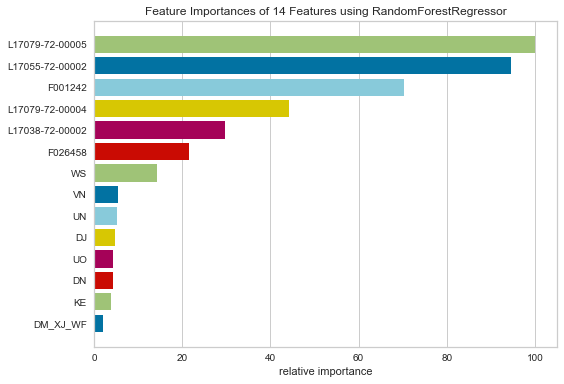

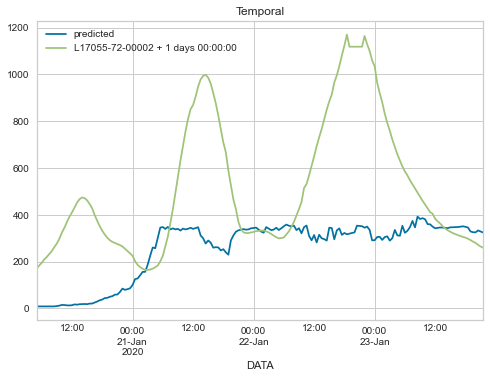

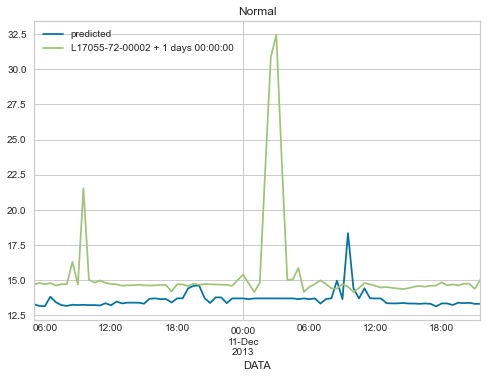

Iteració:  2
CPU times: total: 6.42 s
Wall time: 3min 59s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\69523611.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


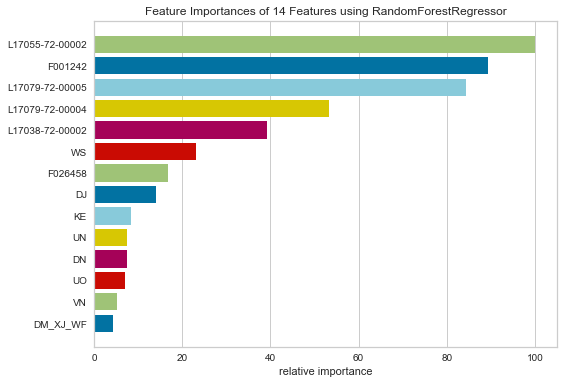

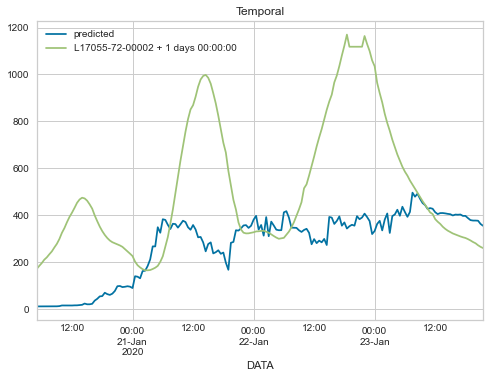

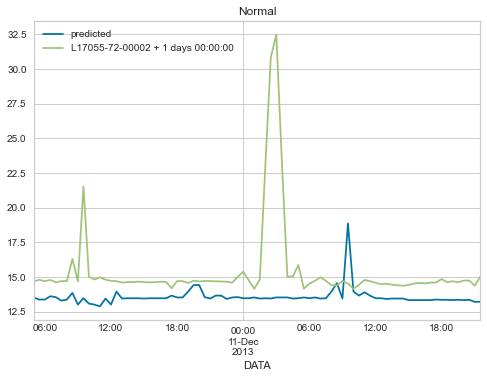

Iteració:  3
CPU times: total: 6.33 s
Wall time: 6min 45s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\69523611.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


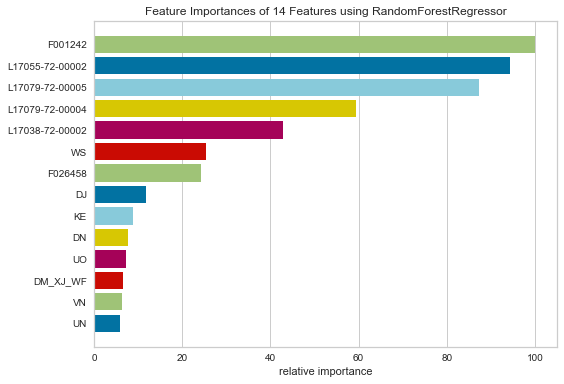

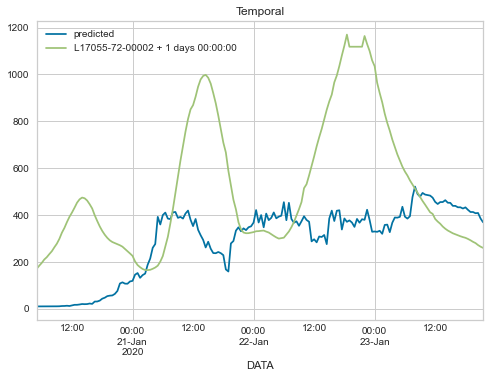

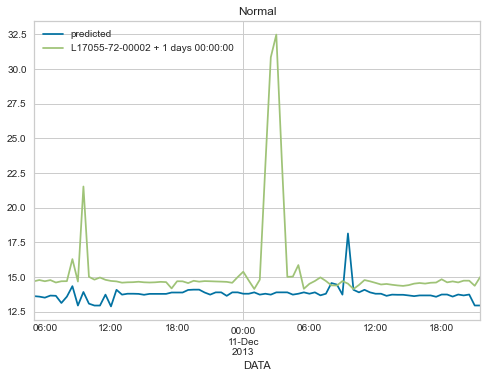

Time:  0:12:26.752795


In [25]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_BaixTery_24hpred
#Df_BaixTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_BaixTerX_24hpred):
    iteracio += 1
    Df_BaixTerX_24hpred_train, Df_BaixTerX_24hpred_test = Df_BaixTerX_24hpred.values[train_index], Df_BaixTerX_24hpred.values[test_index]
    Df_BaixTery_24hpred_train, Df_BaixTery_24hpred_test = Df_BaixTery_24hpred.values.ravel()[train_index], Df_BaixTery_24hpred.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixTerX_24hpred_train, Df_BaixTery_24hpred_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixTerX_24hpred_test, Df_BaixTery_24hpred_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_BaixTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_BaixTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_BaixTerX_24hpred.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/RandomForest_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixTerX_24hpred, Df_BaixTery_24hpred)
    viz.show()
    
    plotYtest = Df_BaixTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_BaixTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [26]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.07332131742887955, 0.1094348875091361, 0.24...",0.477258,24.974293,1 days 00:00:00
1,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.08524677557708253, 0.11598632298328815, 0.1...",0.291348,5.752206,1 days 00:00:00
2,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.08794098041124816, 0.12174101374077478, 0.1...",0.476924,41.50029,1 days 00:00:00


#### XGBoost

Iteració:  1
[13:43:38] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 10.6 s
Wall time: 4min 45s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\157529230.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


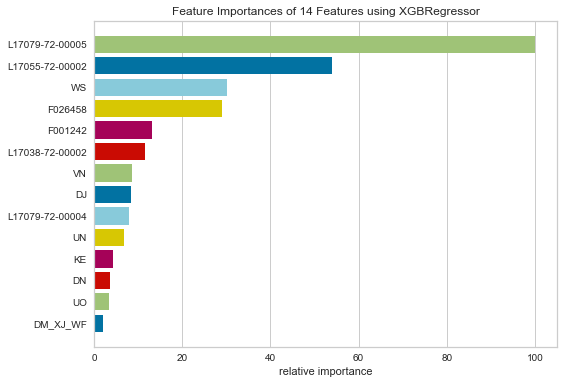

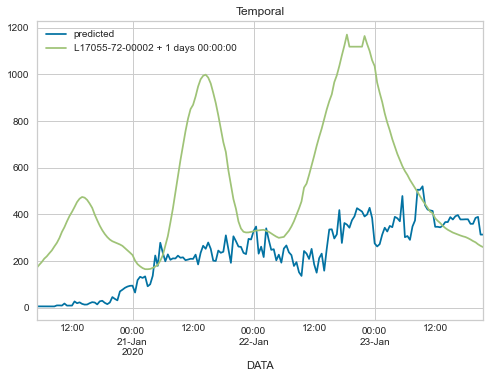

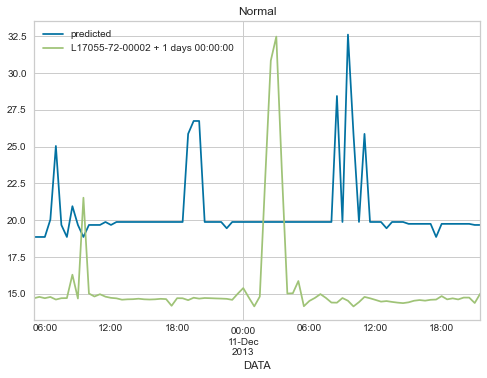

Iteració:  2


C:\Users\Sergi\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[13:53:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 22.3 s
Wall time: 9min 45s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\157529230.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


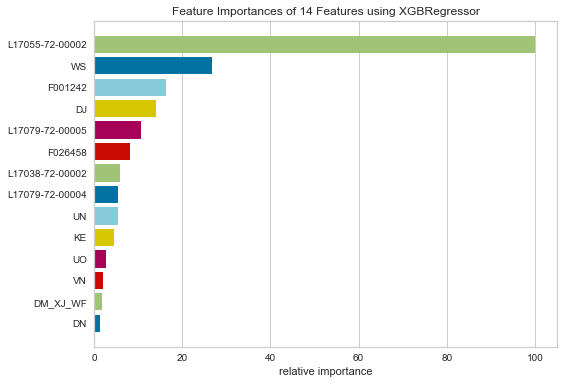

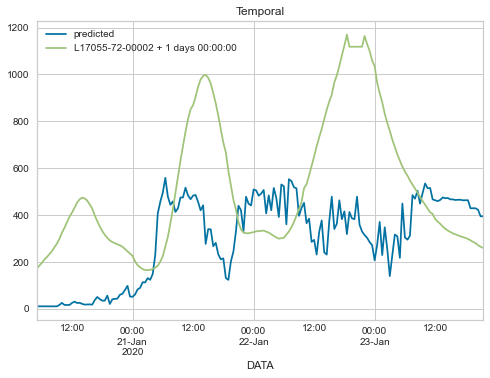

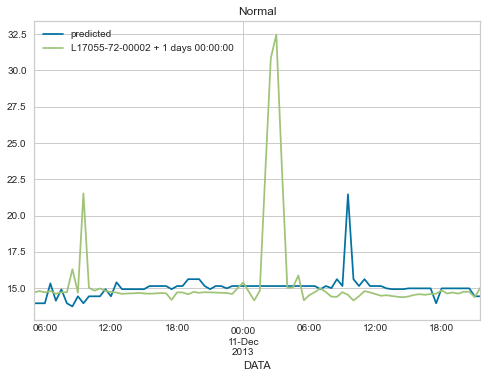

Iteració:  3


C:\Users\Sergi\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[14:07:44] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 29.4 s
Wall time: 14min 20s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\157529230.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


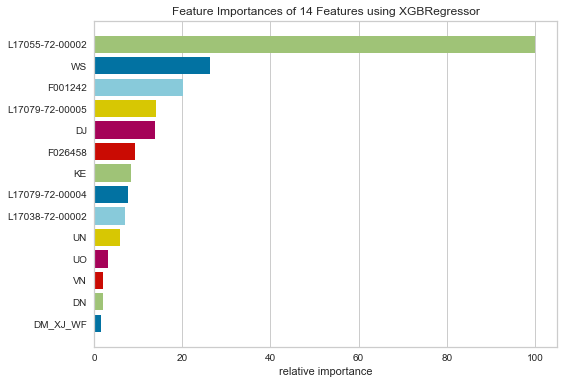

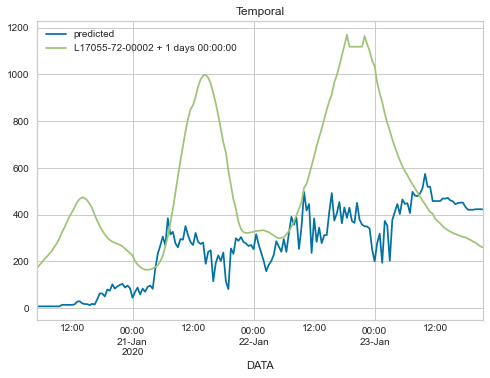

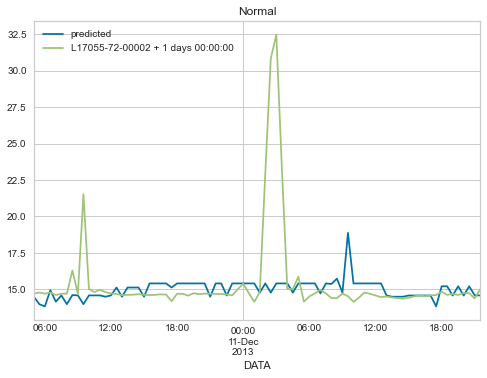

Time:  0:28:53.322129


In [27]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_BaixTery_24hpred
#Df_BaixTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_BaixTerX_24hpred):
    iteracio += 1
    Df_BaixTerX_24hpred_train, Df_BaixTerX_24hpred_test = Df_BaixTerX_24hpred.values[train_index], Df_BaixTerX_24hpred.values[test_index]
    Df_BaixTery_24hpred_train, Df_BaixTery_24hpred_test = Df_BaixTery_24hpred.values.ravel()[train_index], Df_BaixTery_24hpred.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixTerX_24hpred_train, Df_BaixTery_24hpred_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixTerX_24hpred_test, Df_BaixTery_24hpred_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_BaixTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_BaixTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'XGBoost Regressor','Best_Params':bestParams, 'Features':Df_BaixTerX_24hpred.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/XGBRegressor_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixTerX_24hpred, Df_BaixTery_24hpred)
    viz.show()
    
    plotYtest = Df_BaixTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_BaixTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [28]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.07332131742887955, 0.1094348875091361, 0.24...",0.477258,24.974293,1 days 00:00:00
1,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.08524677557708253, 0.11598632298328815, 0.1...",0.291348,5.752206,1 days 00:00:00
2,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.08794098041124816, 0.12174101374077478, 0.1...",0.476924,41.50029,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.041147955, 0.028350184, 0.35307893, 0.04635...",0.477991,24.956767,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.028389333, 0.02671366, 0.052381046, 0.07960...",0.175195,6.205739,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.031528514, 0.034335215, 0.06343943, 0.09112...",0.394202,44.661432,1 days 00:00:00


#### ExtraTrees

Iteració:  1
CPU times: total: 1.56 s
Wall time: 1min 20s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1758313912.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


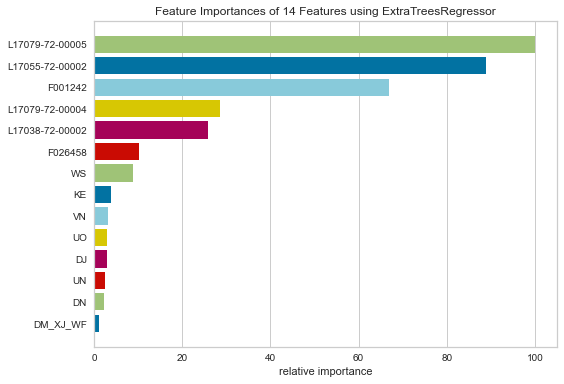

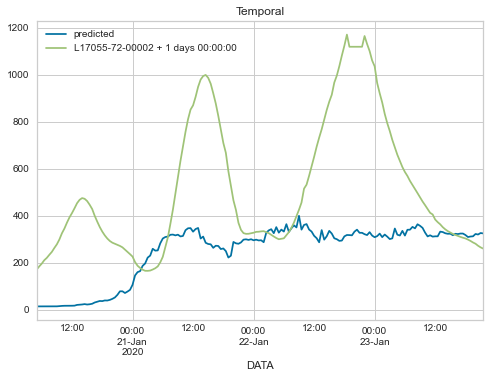

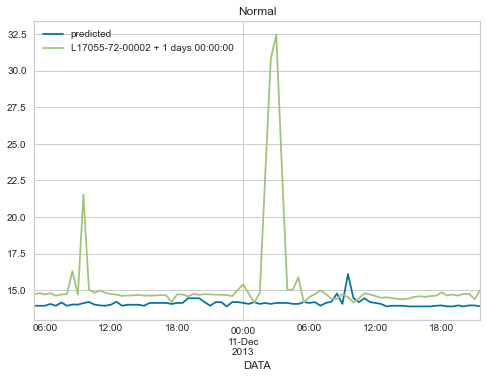

Iteració:  2


C:\Users\Sergi\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: total: 7.03 s
Wall time: 3min 30s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1758313912.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


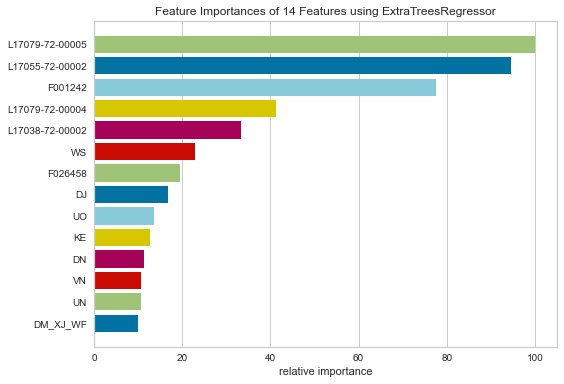

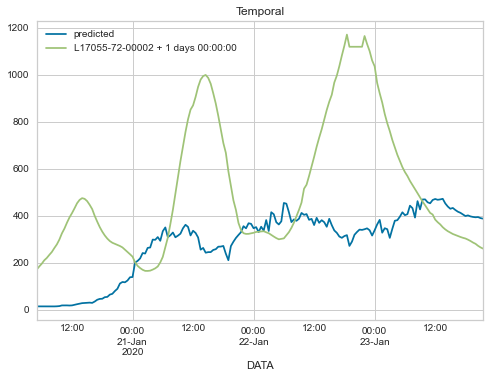

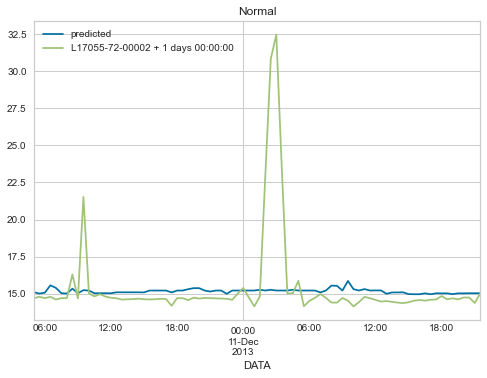

Iteració:  3
CPU times: total: 17.9 s
Wall time: 6min 15s


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\1758313912.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


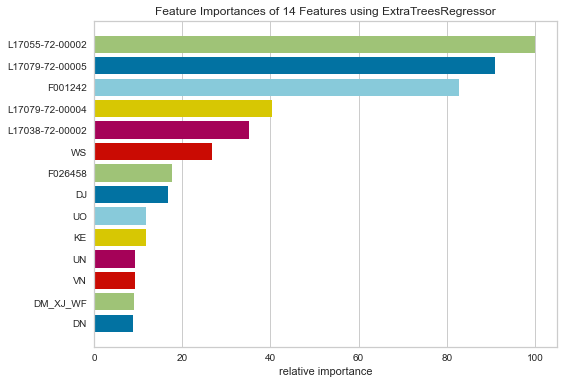

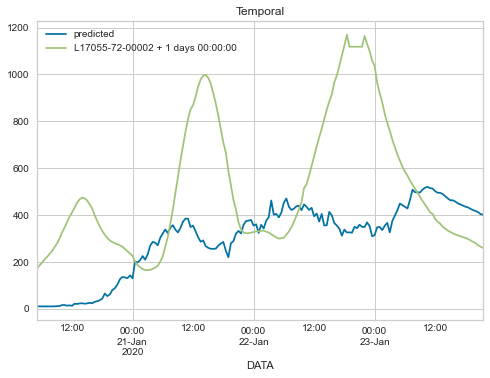

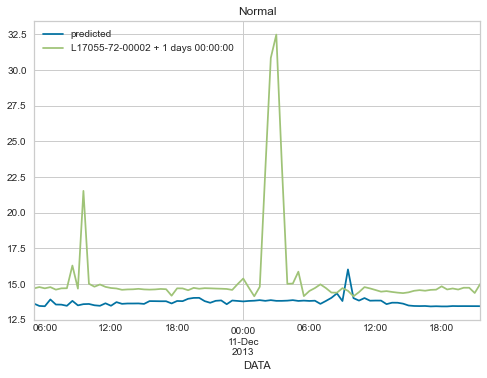

Time:  0:11:13.471030


In [29]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_BaixTery_24hpred
#Df_BaixTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_BaixTerX_24hpred):
    iteracio += 1
    Df_BaixTerX_24hpred_train, Df_BaixTerX_24hpred_test = Df_BaixTerX_24hpred.values[train_index], Df_BaixTerX_24hpred.values[test_index]
    Df_BaixTery_24hpred_train, Df_BaixTery_24hpred_test = Df_BaixTery_24hpred.values.ravel()[train_index], Df_BaixTery_24hpred.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixTerX_24hpred_train, Df_BaixTery_24hpred_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixTerX_24hpred_test, Df_BaixTery_24hpred_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_BaixTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_BaixTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'ExtraTreesRegressor','Best_Params':bestParams, 'Features':Df_BaixTerX_24hpred.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/ExtraTreesRegressor_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixTerX_24hpred, Df_BaixTery_24hpred)
    viz.show()
    
    plotYtest = Df_BaixTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_BaixTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [30]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.07332131742887955, 0.1094348875091361, 0.24...",0.477258,24.974293,1 days 00:00:00
1,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.08524677557708253, 0.11598632298328815, 0.1...",0.291348,5.752206,1 days 00:00:00
2,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.08794098041124816, 0.12174101374077478, 0.1...",0.476924,41.50029,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.041147955, 0.028350184, 0.35307893, 0.04635...",0.477991,24.956767,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.028389333, 0.02671366, 0.052381046, 0.07960...",0.175195,6.205739,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_esti...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.031528514, 0.034335215, 0.06343943, 0.09112...",0.394202,44.661432,1 days 00:00:00
6,ExtraTreesRegressor,"{'max_depth': 8, 'max_features': 'log2', 'n_es...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.0740732537592477, 0.08212981180876483, 0.28...",0.419278,26.322891,1 days 00:00:00
7,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.06999670589242553, 0.08685952489670373, 0.2...",0.172645,6.215323,1 days 00:00:00
8,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17038-72-00002', 'L17079-72-00004', '...","[0.0749323498989874, 0.08561466676697271, 0.19...",0.486602,41.114562,1 days 00:00:00


#### Regresió Linial

Iteració:  1
CPU times: total: 93.8 ms
Wall time: 42.9 ms


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\3942799724.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


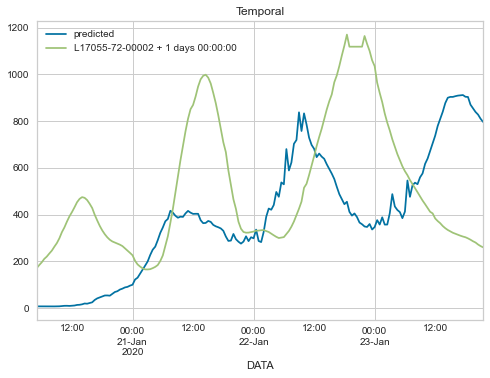

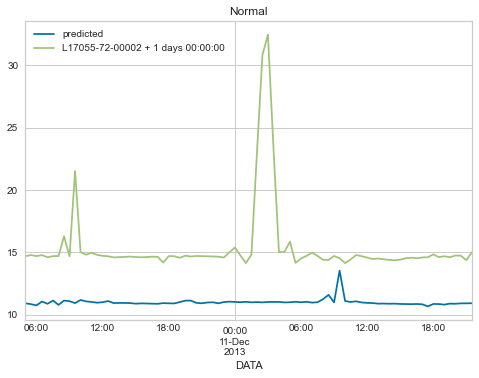

Iteració:  2
CPU times: total: 125 ms
Wall time: 37.9 ms


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\3942799724.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


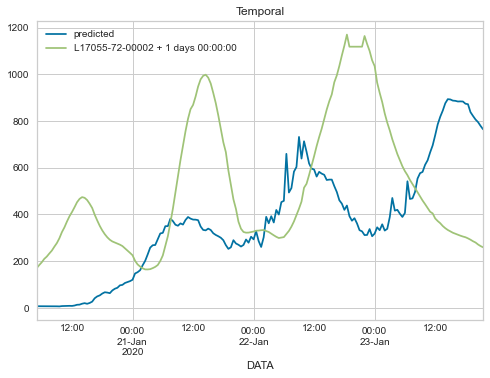

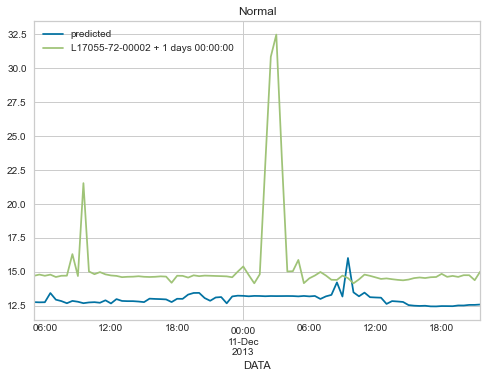

Iteració:  3
CPU times: total: 234 ms
Wall time: 67.8 ms


C:\Users\Sergi\AppData\Local\Temp\ipykernel_3168\3942799724.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)


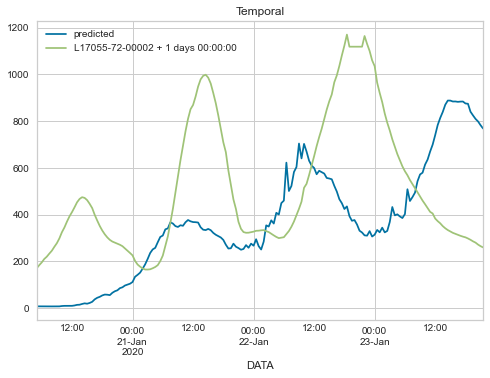

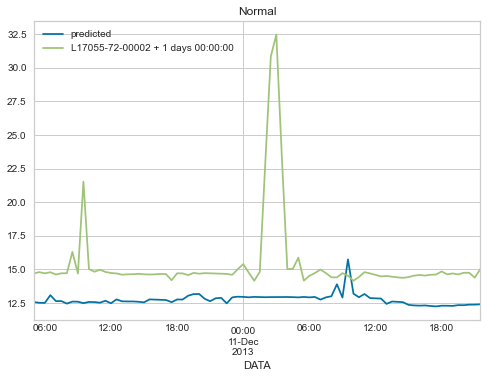

Time:  0:00:01.200890


In [31]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # numero de arbres que construeixo (proporcional en temps)
    'max_features': [1, 'sqrt', 'log2'], # decidir com construeixo l'arbre miro x variables i despres decideixo quina
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}
#Df_BaixTery_24hpred
#Df_BaixTerX_24hpred
iteracio = 0
for train_index, test_index in tscv.split(Df_BaixTerX_24hpred):
    iteracio += 1
    Df_BaixTerX_24hpred_train, Df_BaixTerX_24hpred_test = Df_BaixTerX_24hpred.values[train_index], Df_BaixTerX_24hpred.values[test_index]
    Df_BaixTery_24hpred_train, Df_BaixTery_24hpred_test = Df_BaixTery_24hpred.values.ravel()[train_index], Df_BaixTery_24hpred.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_BaixTerX_24hpred_train, Df_BaixTery_24hpred_train)
        
    score = modelfited.score(Df_BaixTerX_24hpred_test, Df_BaixTery_24hpred_test)
    
    predicty = modelfited.predict(Df_BaixTerX_24hpred_test)
    rmseScore = mean_squared_error(Df_BaixTery_24hpred_test, predicty, squared=False)
    
    nameh = Df_BaixTery_24hpred.columns[0]
    hores = re.findall(r"(\d days .*)", nameh)[0]
    
    new_row = {'Method':'LinearRegression','Best_Params':"no avaliable", 'Features':Df_BaixTerX_24hpred.columns, 'Feature_Importance':"no avaliable", 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)
    
    joblib.dump(modelfited, 'resultsDf/pickle/partBaixa/LinearRegression_'+str(df_results_baixTer.index[-1])+'.pkl', compress = 1)
    
    plotYtest = Df_BaixTery_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_BaixTery_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_BaixTerX_24hpred["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_BaixTerX_24hpred["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = modelfited.predict(plotXtestp.values)
    plotXtest2r = modelfited.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [43]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.07332131742887955, 0.1094348875091361, 0.2470332311102765, 0.17381177096317135, 0.05307976132026423, 0.23322296831829073, 0.011807630495869316, 0.01063678029409144, 0.009606477546357907, 0.013142729029663335, 0.010817011799825086, 0.013573341240926795, 0.03557049567987558, 0.00494159726337226]",0.477258,24.974293,1 days 00:00:00
1,Random Forest,"{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.08524677557708253, 0.11598632298328815, 0.18323974498401424, 0.1942135373940984, 0.03659829061251549, 0.21732611114604083, 0.030387889744812963, 0.016048167507298542, 0.018474851514692192, 0.01614319717997281, 0.015371911486699807, 0.011593158209051078, 0.05014065408037358, 0.00922938758005931]",0.291348,5.752206,1 days 00:00:00
2,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.08794098041124816, 0.12174101374077478, 0.17891128579975726, 0.20505892198558553, 0.049851984042473325, 0.19327357003696247, 0.024092426418034323, 0.015910338600829077, 0.018080666473076122, 0.011945183295723884, 0.014930143401600307, 0.012918120446677707, 0.0519291841013086, 0.013416181245948502]",0.476924,41.50029,1 days 00:00:00
3,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_estimators': 50}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.041147955, 0.028350184, 0.35307893, 0.04635057, 0.102162465, 0.19009347, 0.029886687, 0.013195884, 0.014855327, 0.02411344, 0.01239461, 0.030281143, 0.10668811, 0.0074011562]",0.477991,24.956767,1 days 00:00:00
4,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_estimators': 50}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.028389333, 0.02671366, 0.052381046, 0.07960747, 0.039688144, 0.48747867, 0.06882528, 0.006780341, 0.021633081, 0.026082003, 0.012871952, 0.010208263, 0.13060136, 0.008739443]",0.175195,6.205739,1 days 00:00:00
5,XGBoost Regressor,"{'max_depth': None, 'max_features': 1, 'n_estimators': 50}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.031528514, 0.034335215, 0.06343943, 0.09112481, 0.041752096, 0.4513236, 0.062842004, 0.009211462, 0.03815178, 0.02697609, 0.014046729, 0.00946575, 0.11826197, 0.00754054]",0.394202,44.661432,1 days 00:00:00
6,ExtraTreesRegressor,"{'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}","Index(['L17038-72-00002', 'L17079-72-00004', 'L17079-72-00005', 'F001242', 'F026458', 'L17055-72-00002', 'DJ', 'DN', 'KE', 'UN', 'UO', 'VN', 'WS', 'DM_XJ_WF'], dtype='object')","[0.0740732537592477, 0.08212981180876483, 0.2874272825419713, 0.19220583070590183, 0.029547625560140425, 0.25536092509694985, 0.00826944717506329, 0.006680108982100367, 0.010909678268381316, 0.006983311318302996, 0.00849458114103793, 0.00895071079384179, 0.025590583457340107, 0.003376849390956313]",0.419278,26.322891,1 days 00:00:00
7,ExtraTreesRegressor,"{'max_depth': 25, 'max_features': 1, 'n_estimators': 200}","Index(['L17038-72-00002', 'L17079-72-

In [33]:
df_results_baixTer.to_excel("resultsDf/dfmodels/DfResult_BaixTer.xlsx")

# Proves


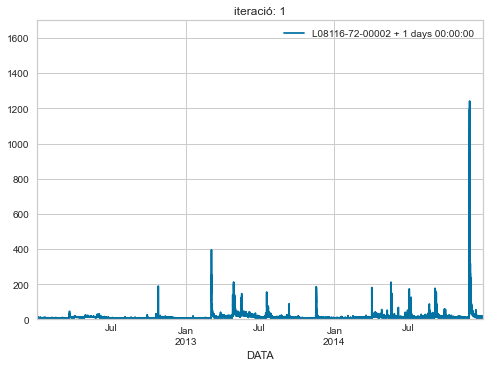

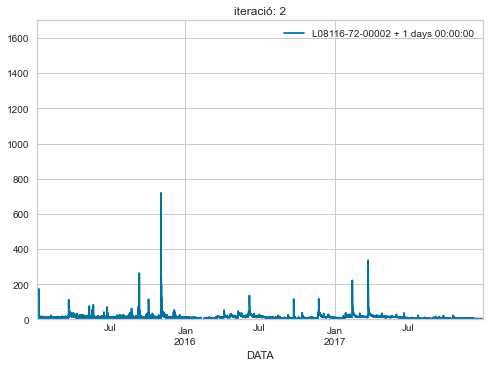

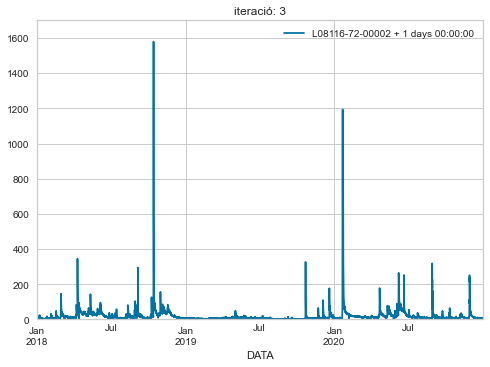

In [60]:
#ALT TER
tscv = TimeSeriesSplit(n_splits=3)
iteracio = 0
for train_index, test_index in tscv.split(Df_AltTerX_24hpred):
    iteracio += 1    
    firtsIndex = test_index[0]
    lastIndex = test_index[-1]
    data = Df_AltTery_24hpred.iloc[firtsIndex:lastIndex]
    #print(firtsIndex)
    #print(lastIndex)
    #print(test_index)
    #print(Df_AltTery_24hpred_test)
    #print(data)
    data.plot(title="iteració: "+str(iteracio))
    plt.ylim([0, 1700])
    plt.show()

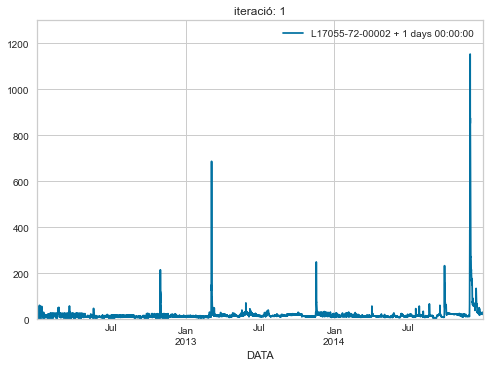

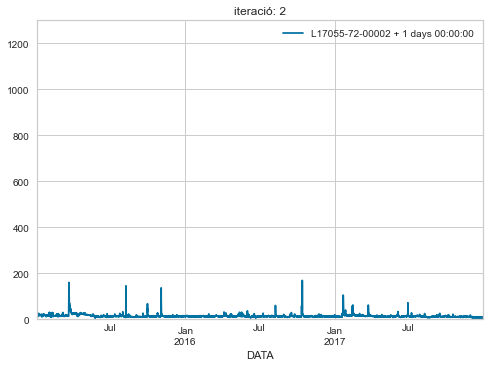

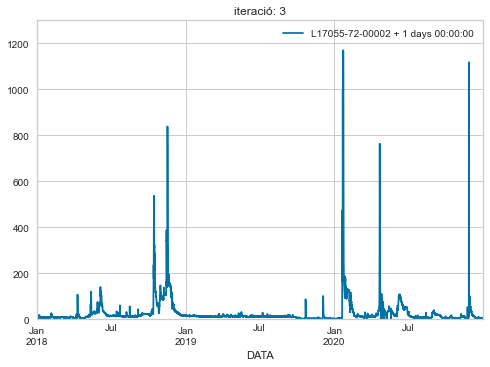

In [57]:
#BAIX TER
tscv = TimeSeriesSplit(n_splits=3)
iteracio = 0
for train_index, test_index in tscv.split(Df_BaixTerX_24hpred):
    iteracio += 1
    firtsIndex = test_index[0]
    lastIndex = test_index[-1]
    data = Df_BaixTery_24hpred.iloc[firtsIndex:lastIndex]
    #print(firtsIndex)
    #print(lastIndex)
    #print(test_index)
    #print(Df_AltTery_24hpred_test)
    #print(data)
    data.plot(title="iteració: "+str(iteracio))
    plt.ylim([0, 1300])
    plt.show()